In [32]:
import os
import json
from argparse import Namespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [33]:
from model import load_history_model
from data import Dataset, create_dataloaders

In [34]:
model_name = 'dnet121-pt'
checkpoint_path = os.path.join('checkpoints', model_name)
checkpoint_best = os.path.join(checkpoint_path, 'best.pt')
checkpoint_latest = os.path.join(checkpoint_path, 'latest.pt')
train_args_path = os.path.join(checkpoint_path, 'train_args.txt')

with open(train_args_path, 'r') as f:
    args = Namespace(**json.load(f))
    args.checkpoint = checkpoint_latest
    
print(args)

Namespace(lr=0.001, bs=50, epochs=200, datafrac=1, freeze_extractor=False, feature_extractor='dnet121', pretrained=True, checkpoint='checkpoints\\dnet121-pt\\latest.pt', name='dnet121-pt')


In [35]:
start_epoch, history, model = load_history_model(args)

Model Loaded with feature extractor=dnet121, pretrained=True and freeze_extractor=False
Model weights loaded from checkpoints\dnet121-pt\latest.pt into cpu


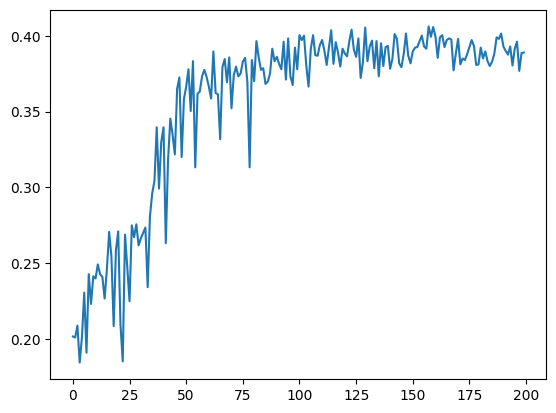

In [36]:
plt.plot(history['test_accuracy'])

In [80]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test

,image_path,age,age_category,class,gender,ethnicity
0,100_0_0_20170112213500903.jpg.chip.jpg,100,"(90, 100]",9,0,0.0
1,100_1_0_20170110183726390.jpg.chip.jpg,100,"(90, 100]",9,1,0.0
2,11_0_0_20170110220453002.jpg.chip.jpg,11,"(10, 20]",1,0,0.0
3,11_0_0_20170110220657089.jpg.chip.jpg,11,"(10, 20]",1,0,0.0
4,11_0_0_20170110224233654.jpg.chip.jpg,11,"(10, 20]",1,0,0.0
...,...,...,...,...,...,...
2792,9_0_4_20170110215354740.jpg.chip.jpg,9,"(0, 10]",0,0,4.0
2793,9_1_0_20170105000600802.jpg.chip.jpg,9,"(0, 10]",0,1,0.0
2794,9_1_0_20170109203410981.jpg.chip.jpg,9,"(0, 10]",0,1,0.0
2795,9_1_0_20170109204512608.jpg.chip.jpg,9,"(0, 10]",0,1,0.0


# Train Set

(array([6173.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

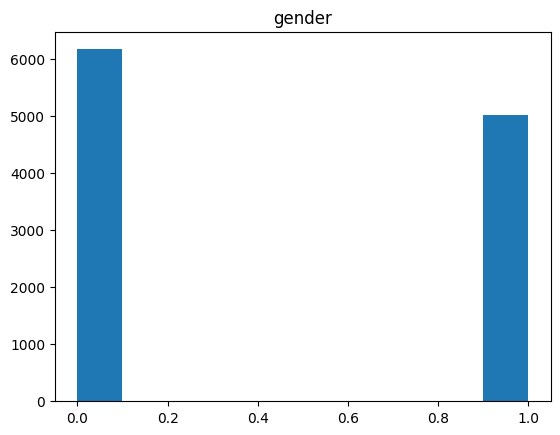

In [38]:
col = "gender"
plt.title(col)
plt.hist(train[col])

There are about 19% more males than females in the dataset

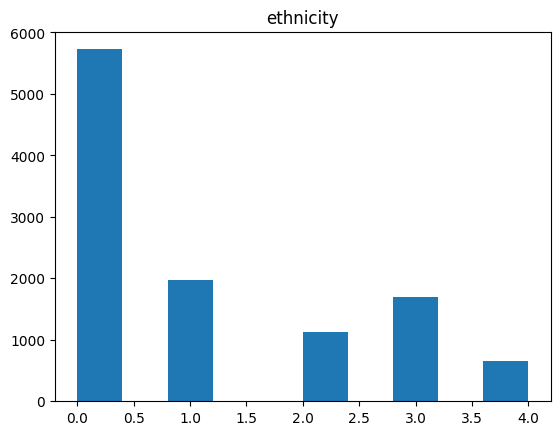

In [39]:
col = "ethnicity"
plt.hist(train[col])
plt.title(col)
plt.show()

# Test set

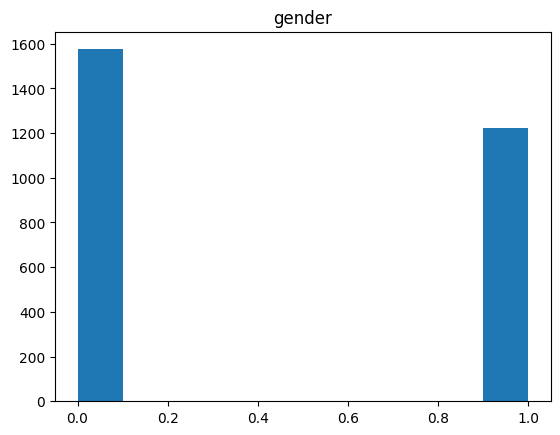

In [40]:
col = "gender"
plt.hist(test[col])
plt.title(col)
plt.show()

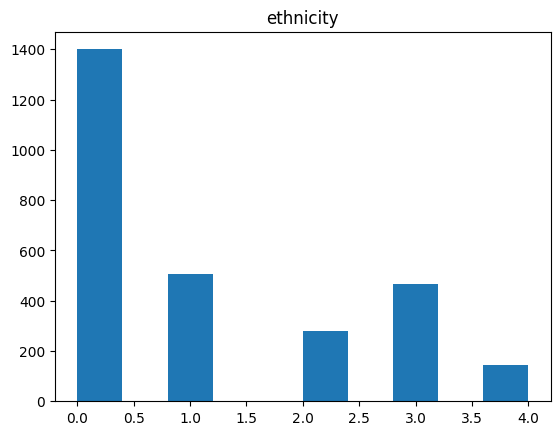

In [41]:
col = "ethnicity"
plt.hist(test[col])
plt.title(col)
plt.show()

In [42]:
if torch.cuda.is_available(): device = 'cuda:0'
else: device = 'cpu'
print(f"{device} used for testing.")

cpu used for testing.


In [43]:
history['test_accuracy'][-1]

0.388988196849823

In [44]:
test_set = Dataset(test)
test_loader = DataLoader(test_set, batch_size=1)

test_acc = 0
with torch.no_grad():
    model.eval()
    for batch_idx, (X, y, age_cat) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)

        oh = model(X).softmax(dim=1)
        test_acc += (oh.argmax(dim=1) == y.argmax(dim=1)).float().sum() 

    test_acc /= len(test_loader.dataset)
    test_acc = test_acc.to('cpu').item()
    print(f"test_acc: {test_acc}", end=" ")

test_acc: 0.38755810260772705 

In [45]:
def accuracyOn(data, col='gender', colval=0):
    
    data = data[data[col] == colval].dropna()

    test_set = Dataset(data)
    test_loader = DataLoader(test_set, batch_size=1)
    
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for batch_idx, (X, y, age_cat) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)

            oh = model(X).softmax(dim=1)
            test_acc += (oh.argmax(dim=1) == y.argmax(dim=1)).float().sum() 

        test_acc /= len(test_loader.dataset)
        test_acc = test_acc.to('cpu').item()
        print(f"test_acc: {test_acc}", end=" ")
        return test_acc

In [46]:
accuracyOn(test, col='gender', colval=0)

test_acc: 0.39174604415893555 

0.39174604415893555

In [47]:
accuracyOn(test, col='gender', colval=1)

test_acc: 0.38216039538383484 

0.38216039538383484

### Custom Binning

In [53]:
data_folder = os.path.join('data', 'CustomBinning')
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

In [114]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [115]:
bins = [0,5,10,15,20,30,45,60,100]
train['age'] = train.image_path.apply(lambda x: int(x.split('_')[0]))
train['age_category'] = pd.cut(train['age'], bins=bins)
train['class'] = train.age_category.apply(lambda x: int(bins.index(x.left)))

test['age'] = test.image_path.apply(lambda x: int(x.split('_')[0]))
test['age_category'] = pd.cut(test['age'], bins=bins)
test['class'] = test.age_category.apply(lambda x: int(bins.index(x.left)))

train.to_csv(os.path.join(data_folder, 'train.csv'))
test.to_csv(os.path.join(data_folder, 'test.csv'))

(array([ 95., 138., 130.,   0., 214., 406.,   0., 677., 658., 479.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

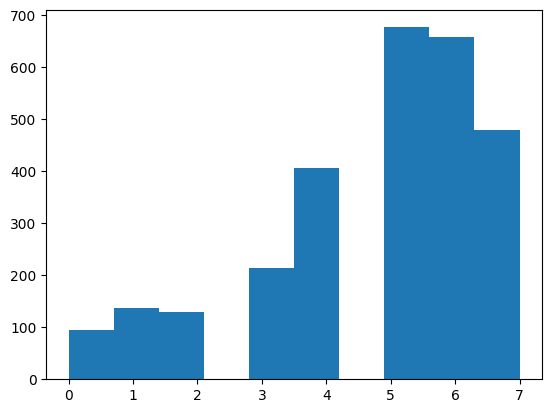

In [116]:
plt.hist(test['class'])